## Iterate Solvers
Many real-world problems of the form Ax = b have tens of thousands of
parameters. Solving such systems with Gaussian elimination or matrix factorizations could require
trillions of floating point operations (FLOPs), which is of course infeasible. Solutions of large systems
must therefore be approximated iteratively. In this lab, we implement three popular iterative methods
for solving large systems: Jacobi, Gauss-Seidel, and Successive Over-Relaxation.

In [1]:
# Standard Import Statements
import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from scipy import linalg as la
from scipy import stats as sts
from scipy import sparse
from scipy import integrate
from scipy import optimize as opt
import autograd.numpy as anp
from autograd.numpy.linalg import solve, norm
from autograd import grad, jacobian


In [2]:
## Problem 1

In [48]:
{
    "tags": [
        "hide_input",
    ]
}
def jacobim(A, b, tol=1e-5, maxiters=5000, plot=False):
    
   
    D = np.diagonal(A)
    Dinv = np.diag(1 / np.diag(A))
    xk = np.zeros(len(b))
    errors = []
    err = tol + 1
    it = 1
    
    while err > tol and it < maxiters:
        
        xkp1 = xk + Dinv @ b - Dinv @ (A @ xk)
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('approximation error in absolute terms')
        plt.title('Convergence of Jacobi Method')
        plt.semilogy(np.arange(1, it, 1), errors)
    return xk

In [26]:
def diag_dom(n, num_entries=None):


    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

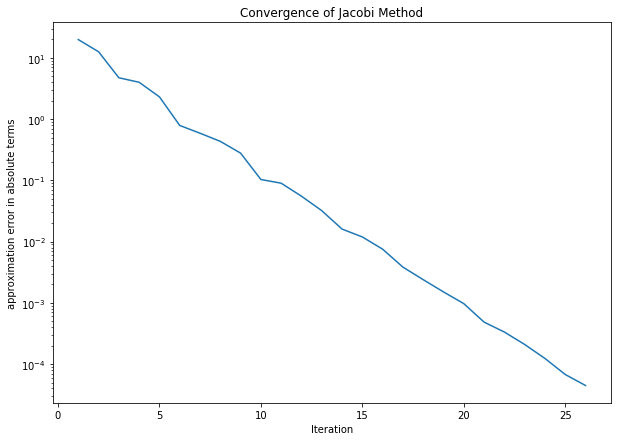

In [27]:
A = diag_dom(10)
b = np.random.random((10,1))
x_j = jacobim(A, b, plot=True)
x_s = la.solve(A, b)

In [28]:
np.allclose(A @ x_s, b),np.allclose(A @ x_s, b)

(True, True)

In [29]:
## Problem 3

In [9]:
def gauss_seidal(A, b, tol=1e-5, maxiters=5000, plot=False):
    
    errors = []
    
    err = tol + 1
    it = 1
    n = len(b)
    
    xk = np.zeros(n)
    
    while err > tol and it < maxiters:
        xkp1 = np.copy(xk)
        for ii in range(n):
            xkp1[ii] = xk[ii] + (1 / A[ii,ii]) * (b[ii] - A[ii, :].T @ xk)
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss Seidal')
        plt.semilogy(np.arange(1, it, 1), errors)
    
    return xk

In [30]:
A = diag_dom(10)
b = np.random.random((10,1))

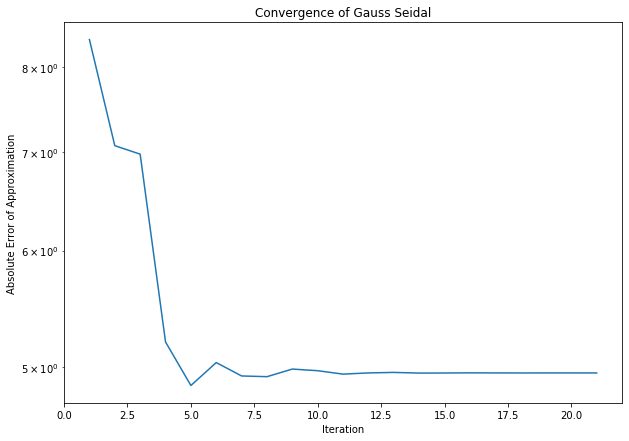

In [31]:
#Plot
x_j = gauss_seidal(A, b, plot=True)
x_s = la.solve(A, b)

In [32]:
def gauss_seidal_sp(A, b, tol=1e-5, maxiters=5000, plot=False):
    
    errors = []
    
    err = tol + 1
    it = 1
    n = len(b)
    xk = np.zeros(n)
    A = A.tocsr()
    
    while err > tol and it < maxiters:
        xkp1 = np.copy(xk)
        for ii in range(n):
            rowstart = A.indptr[ii]
            rowend = A.indptr[ii+1]
            Aix = A.data[rowstart:rowend] @ xk[A.indices[rowstart:rowend]]
            
            xkp1[ii] = xk[ii] + (1 / A[ii,ii]) * (b[ii] - 1 * Aix)
        
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss Seidal')
        plt.semilogy(np.arange(1, it, 1), errors)
    
    return xk

In [33]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)

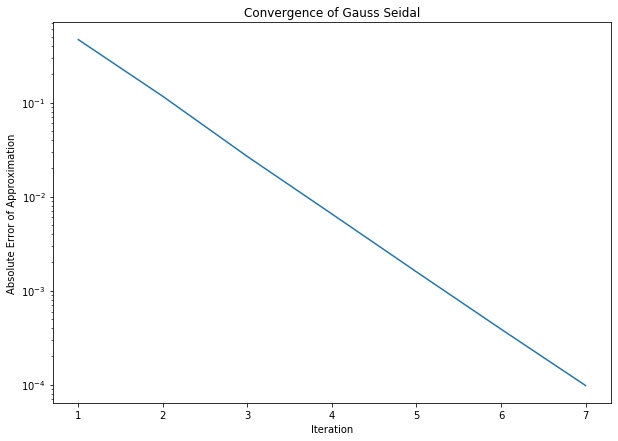

In [34]:
x_j = gauss_seidal_sp(A, b, plot=True)

In [35]:
def gauss_seidal_relax_sp(A, b, w, tol=1e-5, maxiters=5000, plot=False):
    
    errors = []
    
    err = tol + 1
    it = 1
    n = len(b)
    xk = np.zeros(n)
    A = A.tocsr()
    
    while err > tol and it < maxiters:
        xkp1 = np.copy(xk)
        for ii in range(n):
            rowstart = A.indptr[ii]
            rowend = A.indptr[ii+1]
            Aix = A.data[rowstart:rowend] @ xk[A.indices[rowstart:rowend]]
            
            xkp1[ii] = xk[ii] + (w / A[ii,ii]) * (b[ii] - 1 * Aix)
        
        abserr = np.linalg.norm(A@xkp1 - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
    
    if plot:
        fig = plt.figure(figsize=(10,7))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss Seidal')
        plt.semilogy(np.arange(1, it, 1), errors)
    
    return xk, it

In [36]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)
weights = np.linspace(.1, 1, 10)
its = np.zeros(len(weights))
for index, w in enumerate(weights):
    x_j, it = gauss_seidal_relax_sp(A, b, w, plot=False)
    its[index] = it

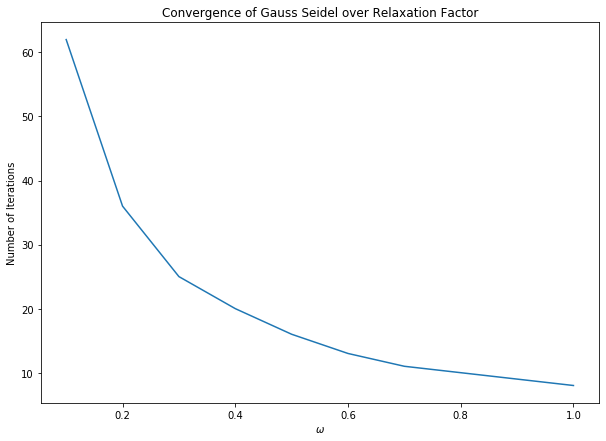

In [37]:
fig = plt.figure(figsize=(10,7))
plt.plot(weights, its)
plt.xlabel(r'$\omega$')
plt.ylabel('Number of Iterations')
plt.title('Convergence of Gauss Seidel over Relaxation Factor')
plt.show()

In [40]:
def heat_map(n, w, tol=1e-8, maxiters=1000, plot=False):
    
    offsets = [-1,0,1]
    B = sparse.diags([1,-4,1], offsets, shape=(n,n))
    I = sparse.diags([1], shape=(n,n))
    
    # Construct A
    rows = []
    for i in range(n):
        row = []
        for j in range(n):
            if j < i - 1:
                row.append(None)
            elif j == i - 1:
                row.append(I)
            elif j == i:
                row.append(B)
            elif j == i + 1:
                row.append(I)
            else:
                row.append(None)
        rows.append(row)
    
    A = sparse.bmat(rows, format='bsr')

    # Construct b
    lilb = np.zeros(n)
    lilb[0] = -100
    lilb[-1] = -100
    b = np.tile(lilb, n)
    
    u, it = gauss_seidal_relax_sp(A, b, w, tol, maxiters, plot=False)
    
    if plot:
        x_domain = np.linspace(0, 1, n + 1)
        y_domain = np.linspace(0, 1, n + 1)
        X, Y = np.meshgrid(x_domain, y_domain)
        u_square = u.reshape((n,n))
        fig = plt.figure(figsize=(10,7))
        plt.pcolormesh(X, Y, u_square, cmap='coolwarm')
        plt.colorbar()
        plt.show()
    return u, it
    

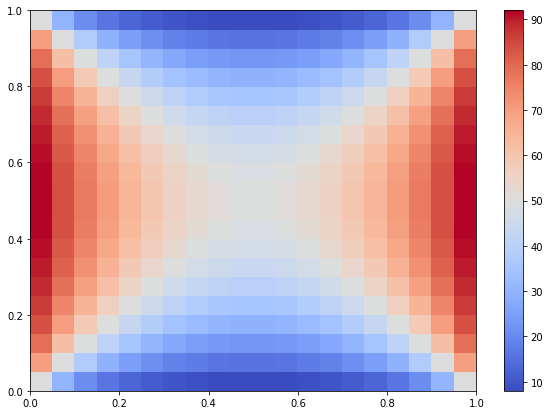

In [41]:
u, it = heat_map(20, 1, plot=True)

In [45]:
n = 4
weights = np.linspace(1, 1.95, 10)
ola = np.zeros(len(weights))
for index, w in enumerate(weights):
    x_j, it = heat_map(n, w, 1e-2, 1000, plot=False)
    ola[index] = it

C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [46]:
weights[np.argmin(ola)]

1.3166666666666667

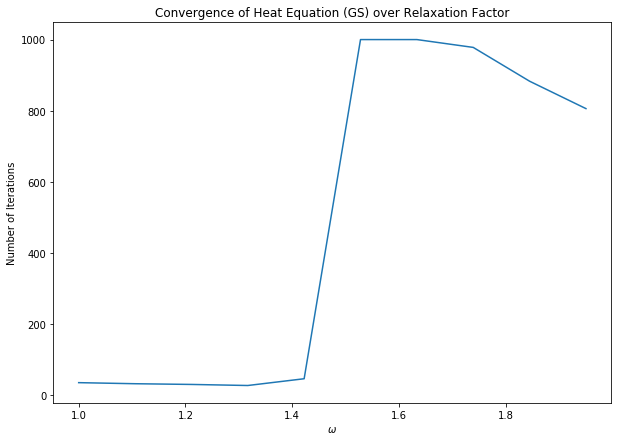

In [47]:
fig = plt.figure(figsize=(10,7))
plt.plot(weights, its)
plt.xlabel(r'$\omega$')
plt.ylabel('Number of Iterations')
plt.title('Convergence of Heat Equation (GS) over Relaxation Factor')
plt.show()